In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
from sklearn.model_selection import train_test_split

TensorFlow 1.x selected.


In [3]:
%cd /content/drive/MyDrive/Train-Openpose-lstm/

/content/drive/MyDrive/Train-Openpose-lstm


## Preparing dataset:

In [4]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "Crouch",
    "Fall",
    "Lyin",
    "Punch",
    "Sit",
    "Stand",
    "Walk"

] 
DATASET_PATH = "data/HAR_pose_activities/database/"


In [5]:
n_steps = 1 # 32 timesteps per series
# Load the networks inputs
def load_X_csv(X_path):
  X_= np.loadtxt(open(X_path, "rb"), delimiter=",", skiprows=1)
  print(X_.shape)
  blocks = int(len(X_) / n_steps)
  print(blocks)
  X_ = np.array(np.split(X_, blocks))
  print(X_.shape)
  return X_ 

def load_Y_csv(Y_path):
  Y_= np.loadtxt(open(Y_path, "rb"), delimiter=",", skiprows=1)
  Y_= Y_.astype(np.int32)
  Y_ = Y_.reshape((len(Y_),1))
  return Y_ -1 

#X_train = load_X(X_train_path)
X_train = load_X_csv(DATASET_PATH + "x.csv")
#X_test = load_X(X_test_path)
#print (load_X(DATASET_PATH + "X_train.txt").shape)
#print (x_train.shape)

#y_train = load_y(y_train_path)
y_train = load_Y_csv(DATASET_PATH + "y.csv")
#y_test = load_y(y_train_path)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print (y_train.shape)
print (y_test.shape)

(18152, 36)
18152
(18152, 1, 36)
(12161, 1)
(5991, 1)


## Set Parameters:


In [6]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
n_classes = 7

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0001 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 60000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = training_data_count *1000  # Loop 300 times on the dataset, ie 300 epochs
batch_size = 128
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(12161, 1, 36) (5991, 1) 0.3831073301363341 0.20073731600086114

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [11]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [12]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
#x = tf.placeholder(tf.float32, [None, 32, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the network:

In [ ]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = list(range(0, len(X_train)))
while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0, len(X_train)))
         
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
   ### Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))
    
    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
PERFORMANCE ON TEST SET:             Batch Loss = 0.5952175855636597, Accuracy = 0.9162076711654663
Iter #9603072:  Learning rate = 0.000007:   Batch Loss = 0.565345, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5952340364456177, Accuracy = 0.9168753027915955
Iter #9604096:  Learning rate = 0.000007:   Batch Loss = 0.610895, Accuracy = 0.9140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5952965021133423, Accuracy = 0.9170422554016113
Iter #9605120:  Learning rate = 0.000007:   Batch Loss = 0.562380, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5954872369766235, Accuracy = 0.9182106256484985
Iter #9606144:  Learning rate = 0.000007:   Batch Loss = 0.534662, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.595556914806366, Accuracy = 0.9185444712638855
Iter #9607168:  Learning rate = 0.000007:   Batch Loss = 0.565476, Accuracy = 0.90625
PERFOR

In [ ]:
#create saver before training

saver = tf.train.Saver()
retrain = True

#check if you want to retrain or import a saved model
if not retrain:
    saver.restore(sess, "/content/drive/MyDrive/Train-Openpose-lstm/Saved model/model.ckpt")
    print("Model restored.")

# code to run inference...

# Check if you want to save your current model
if retrain:
    save_path = saver.save(sess, "/content/drive/MyDrive/Train-Openpose-lstm/Saved model/model.ckpt")
    print("Model saved in file: %s" % save_path)


Model saved in file: /content/drive/MyDrive/Train-Openpose-lstm/Saved model/model.ckpt


## Results:



11877
95007


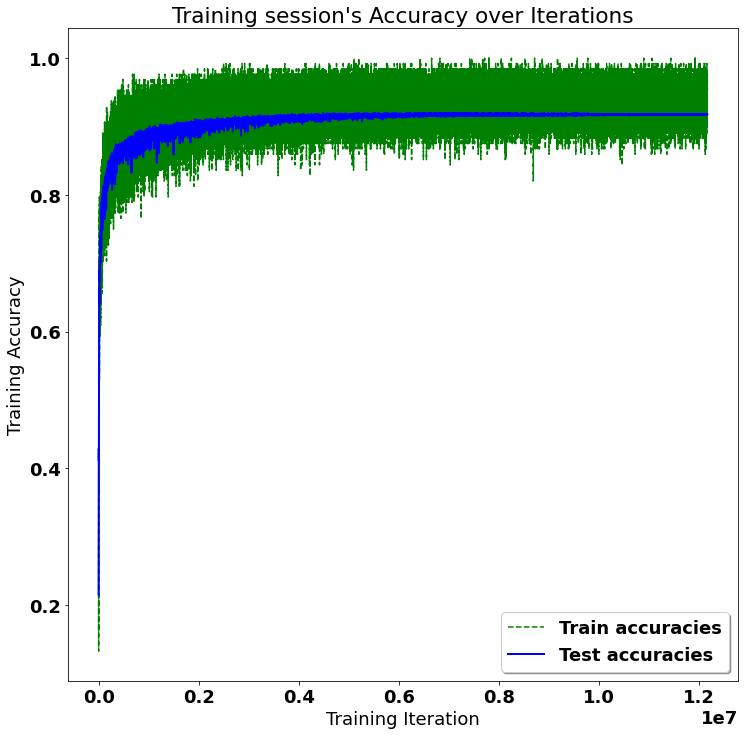

Testing Accuracy: 91.78768396377563%

Precision: 91.69975541198025%
Recall: 91.78768152228342%
f1_score: 91.66359722936697%

Confusion Matrix:
Created using test set of 5991 datapoints, normalised to % of each class in the test dataset
Confusion matrix, without normalization
[[ 597    5    3    1    4    1    2]
 [  25  373   20    5   16   26   56]
 [   1   20  312    0    3    0    1]
 [   2    2    0 1019    0   18    3]
 [   1    3    0    0 1266    1    3]
 [   1    2    1   21    0 1135   81]
 [   7   24    2    9    3  119  797]]
Normalized confusion matrix
[[9.74e-01 8.16e-03 4.89e-03 1.63e-03 6.53e-03 1.63e-03 3.26e-03]
 [4.80e-02 7.16e-01 3.84e-02 9.60e-03 3.07e-02 4.99e-02 1.07e-01]
 [2.97e-03 5.93e-02 9.26e-01 0.00e+00 8.90e-03 0.00e+00 2.97e-03]
 [1.92e-03 1.92e-03 0.00e+00 9.76e-01 0.00e+00 1.72e-02 2.87e-03]
 [7.85e-04 2.35e-03 0.00e+00 0.00e+00 9.94e-01 7.85e-04 2.35e-03]
 [8.06e-04 1.61e-03 8.06e-04 1.69e-02 0.00e+00 9.15e-01 6.53e-02]
 [7.28e-03 2.50e-02 2.08e-03 9.37

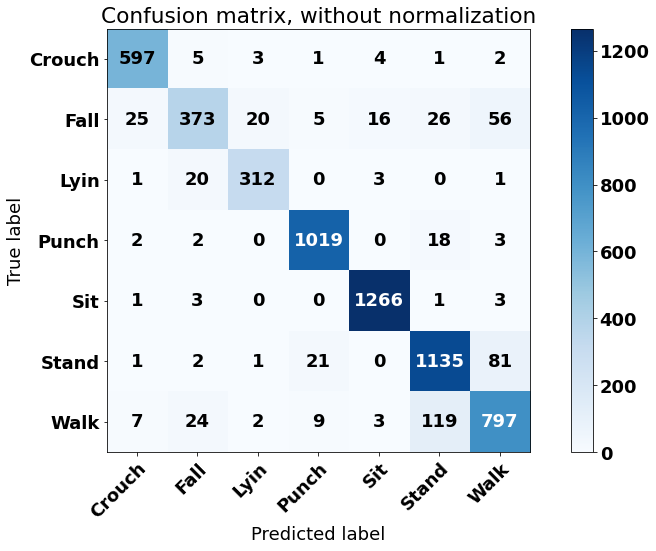

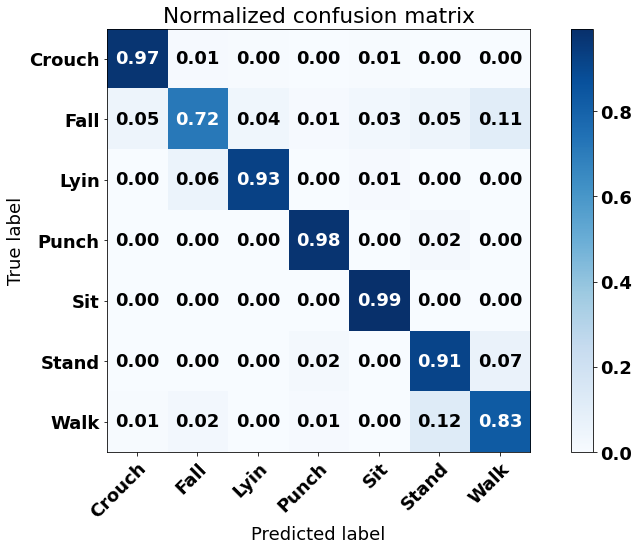

'confusion_matrix = metrics.confusion_matrix(y_test, predictions)\n\n\nprint(confusion_matrix)\nnormalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100\n\n\n# Plot Results: \nwidth = 12\nheight = 12\nplt.figure(figsize=(width, height))\nplt.imshow(\n    normalised_confusion_matrix, \n    interpolation=\'nearest\', \n    cmap=plt.cm.Blues\n)\nplt.title("Confusion matrix \n(normalised to % of total test data)")\nplt.colorbar()\ntick_marks = np.arange(n_classes)\nplt.xticks(tick_marks, LABELS, rotation=90)\nplt.yticks(tick_marks, LABELS)\nplt.tight_layout()\nplt.ylabel(\'True label\')\nplt.xlabel(\'Predicted label\')\nplt.show()\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
# plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
# plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print (len(test_accuracies))
print (len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
from matplotlib.pyplot import figure

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          size=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    if size is None:
        size = (12, 8)
    fig.set_size_inches(size[0], size[1])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
   
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=LABELS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=LABELS, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
 
#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
 
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" 
#         if cm[i, j] &gt thresh 
#         else "black")
 
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')



'''confusion_matrix = metrics.confusion_matrix(y_test, predictions)


print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
'''

In [ ]:
sess.close()
# sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess = tf.Session()
if True:
    saver.restore(sess, "/content/drive/MyDrive/Train-Openpose-lstm/Saved model/model.ckpt")
    print("Model restored.")
X_val_path = DATASET_PATH + "X_val.txt"
X_val = load_X_csv(X_val_path)
# print (X_val)
#print (pred)
preds = sess.run(
   [pred],
   feed_dict={
       x: X_val
  }
)

print (preds)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Train-Openpose-lstm/Saved model/model.ckpt
Model restored.
(31, 36)
31
(31, 1, 36)
[array([[ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.11,  1.  ,  0.87, -0.24, -5.  ,  0.31,  3.04],
       [ 0.01,  2.27,  1.69,  0.34, -5.